### Regression Project

**Hypothesis & Questions**

1.  Is the train dataset complete (has all the required dates)?

2.  Which dates have the lowest and highest sales for each year?

3.  Did the earthquake impact sales?

4.  Are certain groups of stores selling more products? (Cluster, city,
    state, type)

5.  Are sales affected by promotions, oil prices and holidays?

6.  What analysis can we get from the date and its extractable features?

7.  What is the difference between RMSLE, RMSE, MSE (or why is the MAE
    greater than all of them?)

Formulate Hypotheses:

Null Hypothesis (H0): There is no significant difference in sales between products on promotion and products not on promotion.

Alternative Hypothesis (H1): There is a significant difference in sales between products on promotion and products not on promotion.

In [146]:
import pyodbc #just installed with pip
from dotenv import dotenv_values #import the dotenv_values function from the dotenv package
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables=dotenv_values('.env')# Get the values for the credentials you set in the '.env' file
database=environment_variables.get("DATABASE")
server=environment_variables.get("SERVER")
username=environment_variables.get("USERNAME")
password=environment_variables.get("PASSWORD")

connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [4]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server and might take a few seconds to be complete. 
# Check your internet connection if it takes more time than necessary

connection=pyodbc.connect(connection_string)

In [5]:
# Now the sql queries to get the data is what what you see below. 
# Note that you will not have permissions to insert delete or update this database table. 

query_1 = "Select * from dbo.oil"
query_2 = "Select * from dbo.holidays_events"
query_3 = "Select * from dbo.stores"

data_oil = pd.read_sql(query_1,connection)
holiday_data = pd.read_sql(query_2,connection)
store_data = pd.read_sql(query_3,connection)

In [6]:
# preview of first five rows of each dataframe using .head() method
#data_oil
data_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [7]:
#Rename the 'dcoilwtico' to 'Oil_prices"
data_oil.rename(columns={'dcoilwtico': 'Oil_prices'}, inplace=True)

In [8]:
#Check for duplicates
data_oil.duplicated().sum()

0

In [9]:
#holiday_data
holiday_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [10]:
#Check for duplicates
holiday_data.duplicated().sum()

0

In [11]:
#store_data
store_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [12]:
#Check for duplicates
store_data.duplicated().sum()

0

In [13]:
#saving copy of files in  .csv format
data_oil.to_csv('oil_prices.csv')
holiday_data.to_csv('holiday_data.csv')
store_data.to_csv('store_data.csv')

In [14]:
#loading of datasets for review
oil_prices = pd.read_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\oil_prices.csv',parse_dates=['date'], index_col=0)
holiday_data = pd.read_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\holiday_data.csv',parse_dates=['date'], index_col=0)
store_nbr_data = pd.read_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\store_data.csv', index_col=0)


In [15]:
#preview of information summary in the dataframes using .info() method
#1.oil prices data
oil_prices.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   Oil_prices  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.5 KB


In [16]:
#Check of missing values in Holiday data
oil_prices.isna().sum()

date           0
Oil_prices    43
dtype: int64

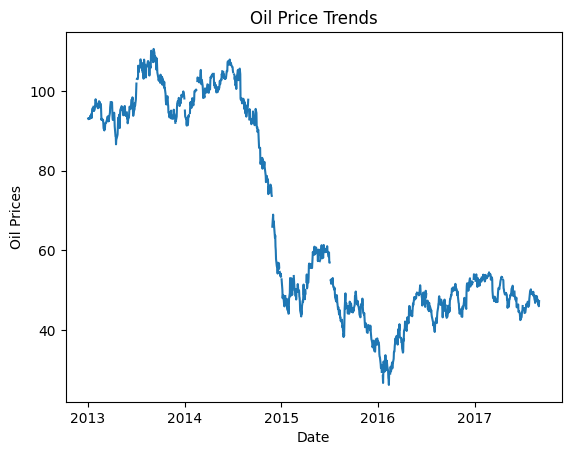

In [17]:
#Visual representation
#Broken regions on line represent missing values
plt.plot(oil_prices['date'], oil_prices['Oil_prices'])
plt.xlabel('Date')
plt.ylabel('Oil Prices')
plt.title('Oil Price Trends')
plt.show()

In [18]:
#2.Holiday_data 
holiday_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 16.7+ KB


In [19]:
holiday_data['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [20]:
#Check of missing values in Holiday data
holiday_data.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [21]:
# Grouping by 'type' and counting occurrences of each 'locale'
locale_counts = holiday_data.groupby('type')['locale'].count()
locale_counts

type
Additional     51
Bridge          5
Event          56
Holiday       221
Transfer       12
Work Day        5
Name: locale, dtype: int64

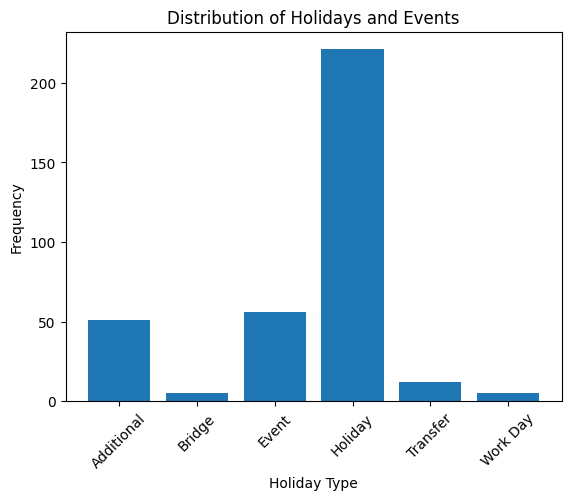

In [22]:
# Creating a bar plot
plt.bar(locale_counts.index, locale_counts.values)
plt.xlabel('Holiday Type')
plt.ylabel('Frequency')
plt.title('Distribution of Holidays and Events')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

In [23]:
# 3. Stores data
store_nbr_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.5+ KB


In [24]:
#Check of missing values in store_data
store_nbr_data.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

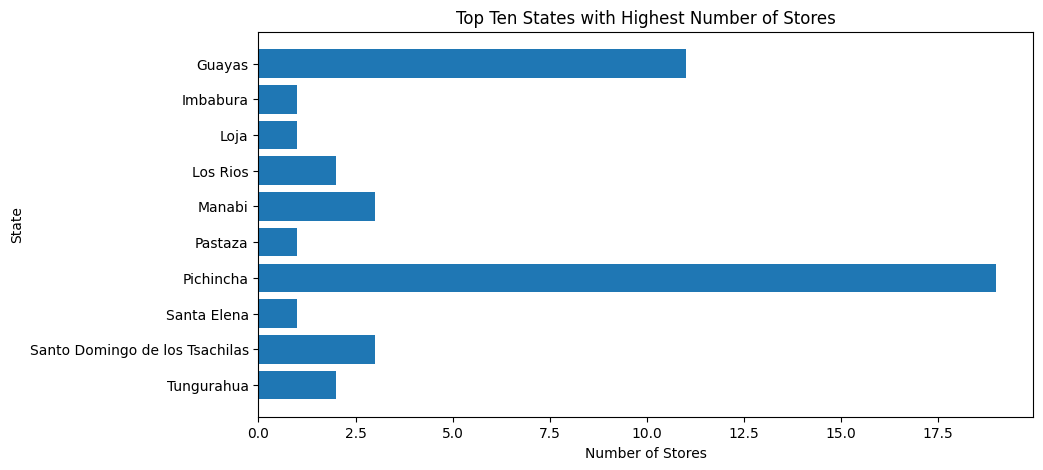

In [25]:
# Grouping by state and counting the number of stores
state_counts = store_nbr_data.groupby('state')['store_nbr'].count()

grouped_state_counts = state_counts.sort_index(ascending=False)

# Selecting the top ten states
top_ten_states = grouped_state_counts.head(10)

# Creating a horizontal bar plot for top ten states
plt.figure(figsize=(10, 5))
plt.barh(top_ten_states.index, top_ten_states.values)
plt.ylabel('State')
plt.xlabel('Number of Stores')
plt.title('Top Ten States with Highest Number of Stores')
plt.show()

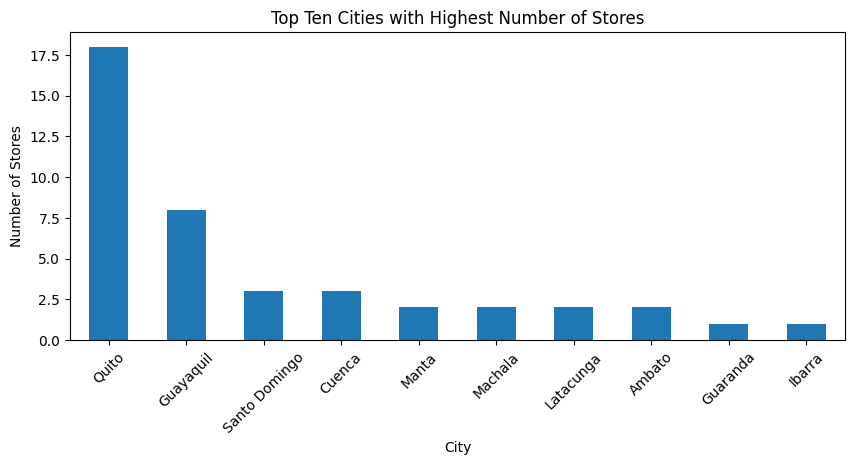

In [26]:
# Grouping by city and counting the number of stores
store_grouping = store_nbr_data.groupby('city')['store_nbr'].count()
store_grouping_sorted = store_grouping.sort_values(ascending=False)

# Selecting the top ten cities
top_ten_cities = store_grouping_sorted.head(10)

# Creating a bar plot for the top ten cities
plt.figure(figsize=(10, 4))
top_ten_cities.plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Number of Stores')
plt.title('Top Ten Cities with Highest Number of Stores')
plt.xticks(rotation=45)
plt.show()

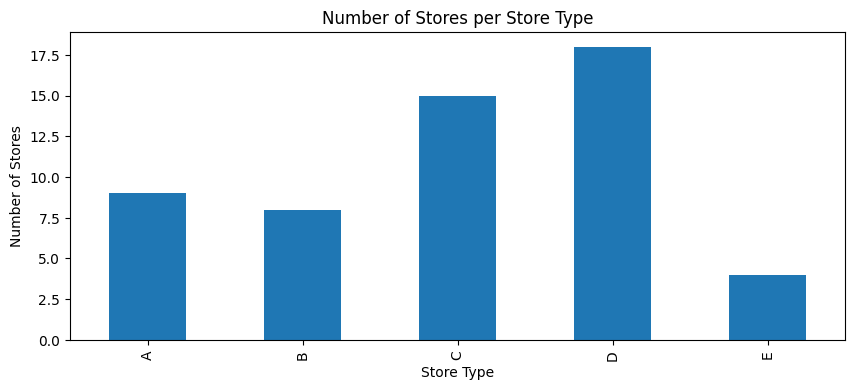

In [27]:
# Creating a bar plot of store count per type
plt.figure(figsize=(10, 4))
store_nbr_data['type'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Store Type')
plt.ylabel('Number of Stores')
plt.title('Number of Stores per Store Type')
#plt.xticks(rotation=45)
plt.show()

In [28]:
#transaction data
transaction_data = pd.read_csv(r"C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\transactions.csv", parse_dates=['date'], index_col='date')
#preview of information summary
transaction_data.info()                          

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83488 entries, 2013-01-01 to 2017-08-15
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   store_nbr     83488 non-null  int64
 1   transactions  83488 non-null  int64
dtypes: int64(2)
memory usage: 1.9 MB


In [29]:
#Any missing values in the transaction_data dataframe
transaction_data.isna().sum()

store_nbr       0
transactions    0
dtype: int64

In [30]:
# Grouping by store_nbr and summing the transactions
transactions_grouped = transaction_data.groupby('store_nbr')['transactions'].sum()
# Series contains the sum of transactions for each store number. 
# Sorting the results in descending order based on the sum of transactions
transactions_sorted = transactions_grouped.sort_values(ascending=False)
#Top ten stores with highest transactions
top_ten_stores = transactions_sorted.head(10)
#Creation of a dataframe table to ease visualization/understanding
top_ten_stores_per_transactions = top_ten_stores.reset_index()
top_ten_stores_per_transactions

,store_nbr,transactions
0,44,7273093
1,47,6535810
2,45,6201115
3,46,5990113
4,3,5366350
5,48,5107785
6,8,4637971
7,49,4574103
8,50,4384444
9,11,3972488


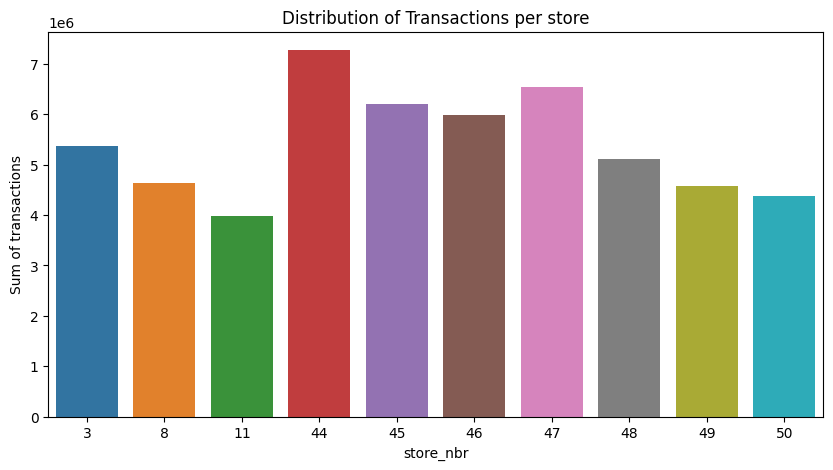

In [31]:
plt.figure(figsize=(10,5))
plt.xlabel('store number')
plt.ylabel('Sum of transactions')
plt.title('Distribution of Transactions per store')
sns.barplot(x=top_ten_stores.index, y=top_ten_stores.values)
plt.show()

In [32]:
#Loading of Train data set
train_data = pd.read_csv(r"C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\train.csv", parse_dates=['date'], index_col='date')
#Preview of first five rows
train_data.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [33]:
train_data.columns

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [34]:
#Preview of information summary in train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [35]:
#Check of missing values in train data
train_data.isna().sum()

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [36]:
#Check of Duplicates
train_data.duplicated().sum()

0

In [37]:
#Loading of test data set
test_data = pd.read_csv(r"C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\test.csv", parse_dates=['date'], index_col='date')
#Preview of first five rows
test_data.head() 

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0


In [38]:
#Preview of information summary in test data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28512 entries, 2017-08-16 to 2017-08-31
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   store_nbr    28512 non-null  int64 
 2   family       28512 non-null  object
 3   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


In [39]:
#Check of missing values in test data
test_data.isna().sum()

id             0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [40]:
#Check of Duplicates
test_data.duplicated().sum()

0

## Cleaning

Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices

Slice of data from Date 2013-01-01 to 2013-01-07 in oil.csv(Daily oil price) 

Addition of the sliced oil prices data to the training set because they fall within same timeframe



In [41]:
start_date = pd.to_datetime('2013-01-01')

end_date = pd.to_datetime('2017-08-15')

#Use of Boolean indexing to slice data within the data range
sliced_df1 =oil_prices[(oil_prices['date'] >= start_date) & (oil_prices['date'] <= end_date)]

sliced_df1

,date,Oil_prices
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
...,...,...
1201,2017-08-09,49.590000
1202,2017-08-10,48.540001
1203,2017-08-11,48.810001
1204,2017-08-14,47.590000


Concatanation of oil prices (sliced_df_1) to the training data set

In [42]:
# Merge the two DataFrames based on the 'date' column
#The how='left' argument specifies that you want to keep all rows from the left DataFrame (train_data), 
#and match them with rows from the right DataFrame (sliced_df1) based on the 'date' column.

merged_train_data = train_data.merge(sliced_df1, on='date', how='left')

#preview of merged train data
merged_train_data.tail(5)

,date,id,store_nbr,family,sales,onpromotion,Oil_prices
3000883,2017-08-15,3000883,9,POULTRY,438.133,0,47.57
3000884,2017-08-15,3000884,9,PREPARED FOODS,154.553,1,47.57
3000885,2017-08-15,3000885,9,PRODUCE,2419.729,148,47.57
3000886,2017-08-15,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57
3000887,2017-08-15,3000887,9,SEAFOOD,16.000,0,47.57


Addition of store.csv medata and transaction data to both the training and testing data

Merging will be based on the similar column in the dataframes

Merging of store.csv with train_data based on column 'store number'

In [43]:
#Check of unique values in store number column of merged_train_data
merged_train_data['store_nbr'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)

In [44]:
# check of  unique values in store number column of store dataframe
store_data['store_nbr'].unique()


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54], dtype=int64)

In [45]:
# Merge the two DataFrames based on the 'store number' column
merged_train_data2 = merged_train_data.merge(store_data, on='store_nbr', how='left')

#preview of the merged train data
merged_train_data2.tail(5)

,date,id,store_nbr,family,sales,onpromotion,Oil_prices,city,state,type,cluster
3000883,2017-08-15,3000883,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6
3000884,2017-08-15,3000884,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6
3000885,2017-08-15,3000885,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6
3000886,2017-08-15,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Quito,Pichincha,B,6
3000887,2017-08-15,3000887,9,SEAFOOD,16.000,0,47.57,Quito,Pichincha,B,6


Merging of transaction data to the training set based on two similar columns, namely, 'date', and 'store_nbr'

Addition of this column is just for analysis purposes, it will be dropped from the training data before modelling.

In [46]:
merged_train_dataset3 = merged_train_data2.merge(transaction_data, on=['date', 'store_nbr'], how='left')

#Preview of changes made to training data
merged_train_dataset3.head(5)

,date,id,store_nbr,family,sales,onpromotion,Oil_prices,city,state,type,cluster,transactions
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,NaN
1,2013-01-01,1,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13,NaN
2,2013-01-01,2,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13,NaN
3,2013-01-01,3,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13,NaN
4,2013-01-01,4,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13,NaN


In [47]:
#check for duplicates
merged_train_dataset3.duplicated().sum()

0

Merging "Holiday Data" to the "merged_train_dataset" on similar column, "date"

In [48]:
#Preview of Holiday_data 'date' column
holiday_data['date']

0     2012-03-02
1     2012-04-01
2     2012-04-12
3     2012-04-14
4     2012-04-21
         ...    
345   2017-12-22
346   2017-12-23
347   2017-12-24
348   2017-12-25
349   2017-12-26
Name: date, Length: 350, dtype: datetime64[ns]

In [49]:
holiday_data[holiday_data['date']=='2017-08-15']

,date,type,locale,locale_name,description,transferred
326,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [50]:
#Choose of date range in 'holiday_data' column that falls within the train data set 

start_date1 = pd.to_datetime('2013-01-01')

end_date1 = pd.to_datetime('2017-08-15')

#Use of Boolean indexing to slice data within the data range
holiday_data_range =holiday_data[(holiday_data['date'] >= start_date1) & (holiday_data['date'] <= end_date1)]
#Preview of changes to dataframe
holiday_data_range['date']

41    2013-01-01
42    2013-01-05
43    2013-01-12
44    2013-02-11
45    2013-02-12
         ...    
322   2017-07-25
323   2017-08-05
324   2017-08-10
325   2017-08-11
326   2017-08-15
Name: date, Length: 286, dtype: datetime64[ns]

In [51]:

merged_train_dataset4 = merged_train_dataset3.merge(holiday_data_range, on='date', how='left')

#Preview of new changes made to training data
merged_train_dataset4.head(5)

,date,id,store_nbr,family,sales,onpromotion,Oil_prices,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,1,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,2,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,3,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,4,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [52]:
#Renaming of 'type_y' column to 'holiday_types' for easy understanding

merged_train_dataset = merged_train_dataset4.rename(columns={'type_y': 'holiday_types', 'type_x':'type'})
#Preview of changes 
merged_train_dataset.columns

Index(['date', 'id', 'store_nbr', 'family', 'sales', 'onpromotion',
       'Oil_prices', 'city', 'state', 'type', 'cluster', 'transactions',
       'holiday_types', 'locale', 'locale_name', 'description', 'transferred'],
      dtype='object')

In [53]:
#A look of unique values in "type_y" column
merged_train_dataset['holiday_types'].unique()

array(['Holiday', nan, 'Work Day', 'Additional', 'Event', 'Transfer',
       'Bridge'], dtype=object)

In [54]:
#A look of unique values in "type_x" column
merged_train_dataset['type'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

Dropping of unnecessary columns(features) that don't have any contribution to the sales, the target

In [55]:
# merged_train_dataset = merged_train_dataset4.drop(columns=['type_x', 'cluster', 'locale', 'locale_name', 'description', 'id', 'transactions'], axis=1,)
# #Preview of changes
# merged_train_dataset.columns

Creation of new column features from 'date' column, namely, 'day', 'Month', and 'year' in train dataset

In [56]:
#Creation of new "year" column
merged_train_dataset['year'] = merged_train_dataset['date'].dt.year

#Creation of new "month" column
merged_train_dataset['month'] = merged_train_dataset['date'].dt.month

#Creation of new "day" column
merged_train_dataset['day'] = merged_train_dataset['date'].dt.day

In [57]:
#shape of the modified train dataset
merged_train_dataset.shape

(3054348, 20)

In [58]:
merged_train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 20 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   id             int64         
 2   store_nbr      int64         
 3   family         object        
 4   sales          float64       
 5   onpromotion    int64         
 6   Oil_prices     float64       
 7   city           object        
 8   state          object        
 9   type           object        
 10  cluster        int64         
 11  transactions   float64       
 12  holiday_types  object        
 13  locale         object        
 14  locale_name    object        
 15  description    object        
 16  transferred    object        
 17  year           int32         
 18  month          int32         
 19  day            int32         
dtypes: datetime64[ns](1), float64(3), int32(3), int64(4), object(9)
memory usage: 431.1+ MB


In [59]:
#Check for duplicates in train dataset
merged_train_dataset.duplicated().sum()

0

In [60]:
# #Drop of duplicates in train dataset
# merged_train_dataset.drop_duplicates(keep=False, inplace=True)

In [61]:
# #Check if all duplicates have been dropped
# merged_train_dataset.duplicated().sum()

In [62]:
#Any Missing values in the modified train dataset
merged_train_dataset.isna().sum()

date                   0
id                     0
store_nbr              0
family                 0
sales                  0
onpromotion            0
Oil_prices        955152
city                   0
state                  0
type                   0
cluster                0
transactions      249117
holiday_types    2551824
locale           2551824
locale_name      2551824
description      2551824
transferred      2551824
year                   0
month                  0
day                    0
dtype: int64

Similar changes will be made to the test dataset as were done to train set

Slice of data from Date 2017-08-16 to 2017-08-31 in oil.csv(Daily oil price) 

Addition of the sliced oil prices data to the test set because they fall within same timeframe

In [63]:
start_date1 = pd.to_datetime('2017-08-16')

end_date1 = pd.to_datetime('2017-08-31')

#Use of Boolean indexing to slice data within the data range
sliced_df2 =oil_prices[(oil_prices['date'] >= start_date1) & (oil_prices['date'] <= end_date1)]

#Preview of sliced data
sliced_df2

,date,Oil_prices
1206,2017-08-16,46.799999
1207,2017-08-17,47.070000
1208,2017-08-18,48.590000
1209,2017-08-21,47.389999
1210,2017-08-22,47.650002
1211,2017-08-23,48.450001
1212,2017-08-24,47.240002
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999


Concatanation of oil prices in sliced_df2 to the test data set

In [64]:
# Merge the two DataFrames based on the 'date' column
merged_test_data = test_data.merge(sliced_df2, on='date', how='left')

#preview of merged train data
merged_test_data.tail(5)

,date,id,store_nbr,family,onpromotion,Oil_prices
28507,2017-08-31,3029395,9,POULTRY,1,47.259998
28508,2017-08-31,3029396,9,PREPARED FOODS,0,47.259998
28509,2017-08-31,3029397,9,PRODUCE,1,47.259998
28510,2017-08-31,3029398,9,SCHOOL AND OFFICE SUPPLIES,9,47.259998
28511,2017-08-31,3029399,9,SEAFOOD,0,47.259998


In [65]:
# Merging of store.csv data with the test_data based on column 'store number'
# Merge the two DataFrames based on the 'store number' column
merged_test_data2 = merged_test_data.merge(store_data, on='store_nbr', how='left')

#preview of the merged train data
merged_test_data2.tail(5)

,date,id,store_nbr,family,onpromotion,Oil_prices,city,state,type,cluster
28507,2017-08-31,3029395,9,POULTRY,1,47.259998,Quito,Pichincha,B,6
28508,2017-08-31,3029396,9,PREPARED FOODS,0,47.259998,Quito,Pichincha,B,6
28509,2017-08-31,3029397,9,PRODUCE,1,47.259998,Quito,Pichincha,B,6
28510,2017-08-31,3029398,9,SCHOOL AND OFFICE SUPPLIES,9,47.259998,Quito,Pichincha,B,6
28511,2017-08-31,3029399,9,SEAFOOD,0,47.259998,Quito,Pichincha,B,6


In [66]:
# Merging of transaction data to the test set based on two similar columns, namely, 'date', and 'store_nbr'
merged_test_data3 = merged_test_data2.merge(transaction_data, on=['date', 'store_nbr'], how='left')

#Preview of changes made to training data
merged_test_data3.tail(5)

,date,id,store_nbr,family,onpromotion,Oil_prices,city,state,type,cluster,transactions
28507,2017-08-31,3029395,9,POULTRY,1,47.259998,Quito,Pichincha,B,6,NaN
28508,2017-08-31,3029396,9,PREPARED FOODS,0,47.259998,Quito,Pichincha,B,6,NaN
28509,2017-08-31,3029397,9,PRODUCE,1,47.259998,Quito,Pichincha,B,6,NaN
28510,2017-08-31,3029398,9,SCHOOL AND OFFICE SUPPLIES,9,47.259998,Quito,Pichincha,B,6,NaN
28511,2017-08-31,3029399,9,SEAFOOD,0,47.259998,Quito,Pichincha,B,6,NaN


In [67]:
merged_test_data3.isna().sum()

date                0
id                  0
store_nbr           0
family              0
onpromotion         0
Oil_prices       7128
city                0
state               0
type                0
cluster             0
transactions    28512
dtype: int64

Merging "Holiday Data" to the "merged_test_dataset" on similar column, "date"

In [68]:
#Choose of date range in 'holiday_data' column that falls within the train data set 

start_date1 = pd.to_datetime('2017-08-16')

end_date2 = pd.to_datetime('2017-08-31')

#Use of Boolean indexing to slice data within the data range
holiday_data_range2 =holiday_data[(holiday_data['date'] >= start_date1) & (holiday_data['date'] <= end_date2)]

In [69]:
merged_test_data4 = merged_test_data3.merge(holiday_data_range2, on='date', how='left')


#Preview of new changes made to training data
merged_test_data4.tail(3)

,date,id,store_nbr,family,onpromotion,Oil_prices,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred
28509,2017-08-31,3029397,9,PRODUCE,1,47.259998,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN
28510,2017-08-31,3029398,9,SCHOOL AND OFFICE SUPPLIES,9,47.259998,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN
28511,2017-08-31,3029399,9,SEAFOOD,0,47.259998,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN


Dropping of unnecessary columns(features) that don't have any contribution to the sales, the target

In [70]:
# merged_test_dataset = merged_test_data4.drop(columns=['type_x', 'cluster', 'locale', 'locale_name', 'description', 'transactions', 'id'], axis=1,)
# #Preview of changes
# merged_test_dataset.columns

In [71]:
#Renaming of 'type_y' column to 'holiday_types' for easy understanding

merged_test_dataset = merged_test_data4.rename(columns={'type_y': 'holiday_types', 'type_x':'type'})
#Preview of changes 
merged_train_dataset.columns

Index(['date', 'id', 'store_nbr', 'family', 'sales', 'onpromotion',
       'Oil_prices', 'city', 'state', 'type', 'cluster', 'transactions',
       'holiday_types', 'locale', 'locale_name', 'description', 'transferred',
       'year', 'month', 'day'],
      dtype='object')

Creation of new column features from 'date' column, namely, 'day', 'Month', and 'year' in test dataset

In [72]:
#Creation of new "year" column
merged_test_dataset['year'] = merged_test_dataset['date'].dt.year

#Creation of new "month" column
merged_test_dataset['month'] = merged_test_dataset['date'].dt.month

#Creation of new "day" column
merged_test_dataset['day'] = merged_test_dataset['date'].dt.day

In [73]:
#Check for Duplicate values
merged_test_dataset.duplicated().sum()

0

In [74]:
#shape of the modified test dataset
merged_test_dataset.shape

(28512, 19)

In [75]:
merged_test_dataset.isna().sum()

date                 0
id                   0
store_nbr            0
family               0
onpromotion          0
Oil_prices        7128
city                 0
state                0
type                 0
cluster              0
transactions     28512
holiday_types    26730
locale           26730
locale_name      26730
description      26730
transferred      26730
year                 0
month                0
day                  0
dtype: int64

### Handling Missing values



Train dataset

In [76]:
#Preview on information summary on modified merged train dataset
merged_train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 20 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   id             int64         
 2   store_nbr      int64         
 3   family         object        
 4   sales          float64       
 5   onpromotion    int64         
 6   Oil_prices     float64       
 7   city           object        
 8   state          object        
 9   type           object        
 10  cluster        int64         
 11  transactions   float64       
 12  holiday_types  object        
 13  locale         object        
 14  locale_name    object        
 15  description    object        
 16  transferred    object        
 17  year           int32         
 18  month          int32         
 19  day            int32         
dtypes: datetime64[ns](1), float64(3), int32(3), int64(4), object(9)
memory usage: 431.1+ MB


In [77]:
#Summary of numerical description on modified training data
merged_train_dataset.describe()

,date,id,store_nbr,sales,onpromotion,Oil_prices,cluster,transactions,year,month,day
count,3054348,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,2.099196e+06,3.054348e+06,2.805231e+06,3.054348e+06,3.054348e+06,3.054348e+06
mean,2015-04-26 12:11:45.717619200,1.504277e+06,2.750000e+01,3.590209e+02,2.617480e+00,6.801587e+01,8.481481e+00,1.697071e+03,2.014842e+03,6.222870e+00,1.565694e+01
min,2013-01-01 00:00:00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.619000e+01,1.000000e+00,5.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00
25%,2014-03-01 00:00:00,7.546768e+05,1.400000e+01,0.000000e+00,0.000000e+00,4.641000e+01,4.000000e+00,1.046000e+03,2.014000e+03,3.000000e+00,8.000000e+00
50%,2015-04-28 12:00:00,1.507572e+06,2.750000e+01,1.100000e+01,0.000000e+00,5.343000e+01,8.500000e+00,1.395000e+03,2.015000e+03,6.000000e+00,1.600000e+01
75%,2016-06-22 00:00:00,2.255120e+06,4.100000e+01,1.960110e+02,0.000000e+00,9.581000e+01,1.300000e+01,2.081000e+03,2.016000e+03,9.000000e+00,2.300000e+01
max,2017-08-15 00:00:00,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02,1.106200e+02,1.700000e+01,8.359000e+03,2.017000e+03,1.200000e+01,3.100000e+01
std,NaN,8.662610e+05,1.558579e+01,1.107286e+03,1.225494e+01,2.569134e+01,4.649735e+00,9.668317e+02,1.345607e+00,3.374251e+00,8.801398e+00


In [78]:
#Check of missing values in modified train data set
print('-*Missing values in train dataset*-')
print('**' * 16)
for column in merged_train_dataset.columns:
    missin_vals = merged_train_dataset[column].isna().sum()
    print(f'Sum of missing values in column {column}: {missin_vals}') 

-*Missing values in train dataset*-
********************************
Sum of missing values in column date: 0
Sum of missing values in column id: 0
Sum of missing values in column store_nbr: 0
Sum of missing values in column family: 0
Sum of missing values in column sales: 0
Sum of missing values in column onpromotion: 0
Sum of missing values in column Oil_prices: 955152
Sum of missing values in column city: 0
Sum of missing values in column state: 0
Sum of missing values in column type: 0
Sum of missing values in column cluster: 0
Sum of missing values in column transactions: 249117
Sum of missing values in column holiday_types: 2551824
Sum of missing values in column locale: 2551824
Sum of missing values in column locale_name: 2551824
Sum of missing values in column description: 2551824
Sum of missing values in column transferred: 2551824
Sum of missing values in column year: 0
Sum of missing values in column month: 0
Sum of missing values in column day: 0


missing values in Oil_prices column

In [79]:
#Numerical description of oil prices column 
merged_train_dataset['Oil_prices'].describe()

count    2.099196e+06
mean     6.801587e+01
std      2.569134e+01
min      2.619000e+01
25%      4.641000e+01
50%      5.343000e+01
75%      9.581000e+01
max      1.106200e+02
Name: Oil_prices, dtype: float64

Interpolation can be a more sophisticated way to fill missing values, especially in time series data or other sequential data, as it considers the values around the missing data points to estimate a reasonable value.
It takes into account the relationships between data points for a more informed estimate of missing values.

In [80]:
#Set "date" column to be an index
merged_train_dataset.set_index('date', inplace=True)

Use of interpolation to fill NAN values in train_dataset

In [81]:
# Use interpolation to fill missing values in the specified column
merged_train_dataset['Oil_prices'] = merged_train_dataset['Oil_prices'].interpolate(method='time')

In [82]:
# Any Missing values in 'Oil_prices' column after interpolation? A few Missing values remaining

print(f'Missing values in Oil_prices column after interpolation:',merged_train_dataset['Oil_prices'].isna().sum())

Missing values in Oil_prices column after interpolation: 1782


Use of backward fill to replace remaining NAN values in "oil_prices" column

In [83]:
merged_train_dataset['Oil_prices'].fillna(method='bfill', inplace=True)

In [84]:
# Any remaining Missing values in 'Oil_prices' column after Using backward fill (bfill) 

print(f'Missing values in Oil_prices column after Using backward fill (bfill) :',merged_train_dataset['Oil_prices'].isna().sum())

Missing values in Oil_prices column after Using backward fill (bfill) : 0


missing values in 'holiday_types' column

Filling missing values in 'holiday_types' columnn of train dataset with "Not_a_Holiday"

This is because there are days that were not holdays and product sales are affected by Holidays

Similar changes will be effected to the test dataset

In [85]:
#Filling missing values in 'holiday_types' column of train dataset with 'Not a Holiday'
merged_train_dataset['holiday_types'].fillna('Not a Holiday', inplace=True)

#Missing values in 'transferred' column

The missing values are a result of the additional category "Not a Holiday" in the 'holiday_types' column

Decide to impute missing values with "False" because a non existent holiday cannot be transffered to another date.

In [86]:
#Filling missing values in 'transferred' column of train dataset with 'False'
merged_train_dataset['transferred'].fillna('False', inplace=True)

In [87]:
#Check missing values in remaining columns
merged_train_dataset.isna().sum()

id                     0
store_nbr              0
family                 0
sales                  0
onpromotion            0
Oil_prices             0
city                   0
state                  0
type                   0
cluster                0
transactions      249117
holiday_types          0
locale           2551824
locale_name      2551824
description      2551824
transferred            0
year                   0
month                  0
day                    0
dtype: int64

In [88]:
#Saving a copy of combined train set for powerbi visualization
merged_train_dataset.to_csv('merged_train_dataset_BI.csv')

## Correlation Analysis

Calculate the correlation between numerical features and the target variable (sales). Use the corr method in pandas

In [89]:
#Select features with high absolute correlation values, as they are likely to have a stronger influence on the target variable.

# Select only numerical columns
numerical_columns = merged_train_dataset.select_dtypes(include=['number'])

# Calculate the correlation matrix for numerical columns
correlation_matrix = numerical_columns.corr()

relevant_features = correlation_matrix['sales'].sort_values(ascending=False)
relevant_features

sales           1.000000
onpromotion     0.428241
transactions    0.214848
id              0.086102
year            0.081320
store_nbr       0.041273
cluster         0.038537
month           0.020250
day            -0.011972
Oil_prices     -0.075570
Name: sales, dtype: float64

Visualization of correlation

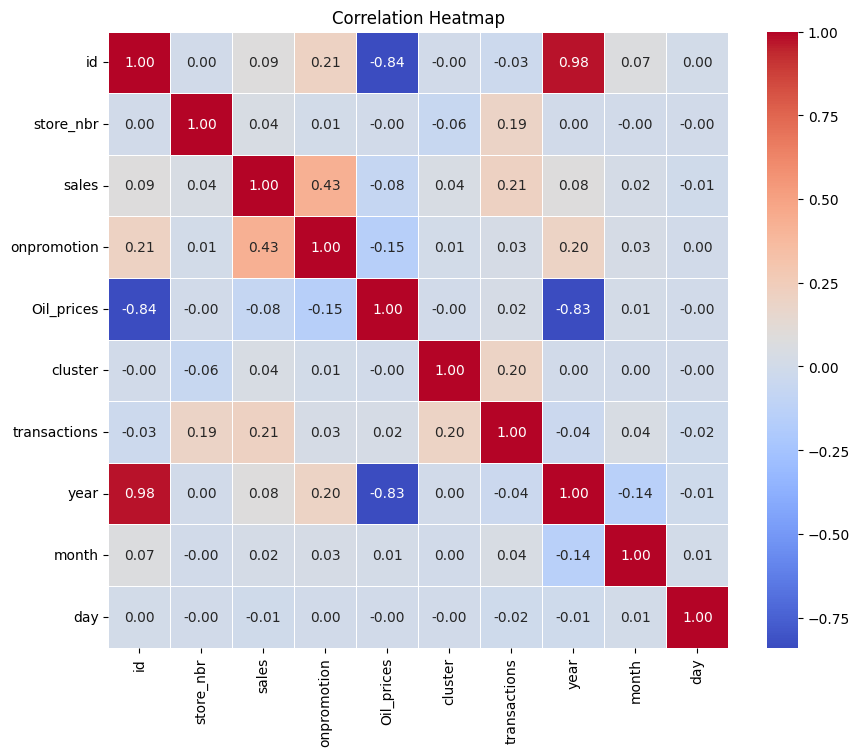

In [90]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

The heatmap shows that Onpromotion has the highest correlation to sales amongst all columns. This depicts that promotions is ideal to increase sales. This is followed by transactions, and obviously more transactions will lead to increased sales. Interestingly, Oil prices has a high negative correlation that some other columns, this are 'store_nbr', 'cluster', 'month' and 'day', meaning oil prices negatively impact daily sales.

Dropping of unnecessary columns(features) that don't have any contribution to the sales, the target

Decided to drop transactions columns because it could be availedin test dataset; we cannot have transactions without predicted sales target

Dropped "cluster" because it has low correlation to sales

Dropped "id" for it had low information value

Dropped 'locale', 'locale_name', and 'description' for they had large number of missing values and I had no clear strategy of imputing them.


In [91]:
merged_train_dataset = merged_train_dataset.drop(columns=['type', 'cluster', 'locale', 'locale_name', 'description', 'id', 'transactions'], axis=1,)
#Preview of changes
merged_train_dataset.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'Oil_prices', 'city',
       'state', 'holiday_types', 'transferred', 'year', 'month', 'day'],
      dtype='object')

In [92]:
merged_train_dataset.isna().sum()

store_nbr        0
family           0
sales            0
onpromotion      0
Oil_prices       0
city             0
state            0
holiday_types    0
transferred      0
year             0
month            0
day              0
dtype: int64

In [93]:
merged_train_dataset.shape

(3054348, 12)

Handling NAN values in test_dataset


In [94]:
#Preview on information summary on modified merged test dataset
merged_test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           28512 non-null  datetime64[ns]
 1   id             28512 non-null  int64         
 2   store_nbr      28512 non-null  int64         
 3   family         28512 non-null  object        
 4   onpromotion    28512 non-null  int64         
 5   Oil_prices     21384 non-null  float64       
 6   city           28512 non-null  object        
 7   state          28512 non-null  object        
 8   type           28512 non-null  object        
 9   cluster        28512 non-null  int64         
 10  transactions   0 non-null      float64       
 11  holiday_types  1782 non-null   object        
 12  locale         1782 non-null   object        
 13  locale_name    1782 non-null   object        
 14  description    1782 non-null   object        
 15  transferred    1782

In [95]:
#Check of missing values in modified test data set
print('-*Missing values in test dataset*-')
print('**' * 16)
for column in merged_test_dataset.columns:
    missin_vals = merged_test_dataset[column].isna().sum()
    print(f'Sum of missing values in column {column}: {missin_vals}') 

-*Missing values in test dataset*-
********************************
Sum of missing values in column date: 0
Sum of missing values in column id: 0
Sum of missing values in column store_nbr: 0
Sum of missing values in column family: 0
Sum of missing values in column onpromotion: 0
Sum of missing values in column Oil_prices: 7128
Sum of missing values in column city: 0
Sum of missing values in column state: 0
Sum of missing values in column type: 0
Sum of missing values in column cluster: 0
Sum of missing values in column transactions: 28512
Sum of missing values in column holiday_types: 26730
Sum of missing values in column locale: 26730
Sum of missing values in column locale_name: 26730
Sum of missing values in column description: 26730
Sum of missing values in column transferred: 26730
Sum of missing values in column year: 0
Sum of missing values in column month: 0
Sum of missing values in column day: 0


In [96]:
#Set "date" column to be an index
merged_test_dataset = merged_test_dataset.set_index('date')

Use of interpolation to fill NAN values in 'Oil_prices' column of test_dataset

In [97]:
# Use interpolation to fill missing values in the 'Oil_prices' column
merged_test_dataset['Oil_prices'] = merged_test_dataset['Oil_prices'].interpolate(method='time')

Filling missing values in 'holiday_types' columnn of test dataset with "Not_a_Holiday"

In [98]:
#Check of unique values in 'holiday_types' column
merged_test_dataset['holiday_types'].unique()

array([nan, 'Holiday'], dtype=object)

In [99]:
#Filling up Missing values with 'Not a Holiday'
merged_test_dataset['holiday_types'].fillna('Not a Holiday', inplace=True)

In [100]:
#Filling missing values in 'transferred' column of test dataset with 'False'
merged_test_dataset['transferred'].fillna('False', inplace=True)

Dropping of unnecessary columns(features) that don't have any contribution to the sales, the target

In [101]:
merged_test_dataset = merged_test_dataset.drop(columns=['type', 'cluster', 'locale', 'locale_name', 'description', 'id', 'transactions'], axis=1,)
#Preview of changes
merged_test_dataset.columns

Index(['store_nbr', 'family', 'onpromotion', 'Oil_prices', 'city', 'state',
       'holiday_types', 'transferred', 'year', 'month', 'day'],
      dtype='object')

In [102]:
#Check missing values after filling up missing values
merged_test_dataset.isna().sum()

store_nbr        0
family           0
onpromotion      0
Oil_prices       0
city             0
state            0
holiday_types    0
transferred      0
year             0
month            0
day              0
dtype: int64

In [103]:
merged_test_dataset.shape

(28512, 11)

In [104]:
#Saving copies of modified train and test data sets to my working directory
merged_train_dataset.to_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\train_dataset.csv')

merged_test_dataset.to_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\test_dataset.csv')


### Loading of Clean Train Dataset

In [105]:
train_data = pd.read_csv(r'C:\Users\WORLDAX COMPUTERS\Python Projects\LP3_DAP_Project\LP3-Regression-Project\Datasets\train_dataset.csv', parse_dates=['date'], index_col=None)
train_data.head(3)

,date,store_nbr,family,sales,onpromotion,Oil_prices,city,state,holiday_types,transferred,year,month,day
0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.139999,Quito,Pichincha,Holiday,False,2013,1,1
1,2013-01-01,1,BABY CARE,0.0,0,93.139999,Quito,Pichincha,Holiday,False,2013,1,1
2,2013-01-01,1,BEAUTY,0.0,0,93.139999,Quito,Pichincha,Holiday,False,2013,1,1


In [106]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 13 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   store_nbr      int64         
 2   family         object        
 3   sales          float64       
 4   onpromotion    int64         
 5   Oil_prices     float64       
 6   city           object        
 7   state          object        
 8   holiday_types  object        
 9   transferred    bool          
 10  year           int64         
 11  month          int64         
 12  day            int64         
dtypes: bool(1), datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 282.5+ MB


In [107]:
train_data.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'Oil_prices',
       'city', 'state', 'holiday_types', 'transferred', 'year', 'month',
       'day'],
      dtype='object')

#### Visualization :EDA

Hypothesis & Questions

1.  Is the train dataset complete (has all the required dates)?

In [108]:

# # Convert the 'date' column to a datetime object
#train_data['date'] = pd.to_datetime(train_data['date'])

#The start and end dates for the expected range
expected_start_date = '2013-01-01'
expected_end_date = '2017-08-15'

# Convert the expected start and end dates to datetime objects
expected_start_date = pd.to_datetime(expected_start_date)
expected_end_date = pd.to_datetime(expected_end_date)

# Generate the list of expected dates within your range
expected_dates = pd.date_range(start=expected_start_date, end=expected_end_date, freq='D')

# Find missing dates
missing_dates = expected_dates[~expected_dates.isin(train_data['date'])]

if len(missing_dates) == 0:
    print("The dataset contains all the required dates.")
else:
    print("The dataset has missing dates:", missing_dates)


The dataset has missing dates: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


Decided not to include the missing christmas dates for I don't have any historical data for the missing dates

I will not make any predictions or forecasts for those dates

2.  Which dates have the lowest and highest sales for each year?

In [109]:
# Group the data by year and find the rows with the lowest and highest sales
result = train_data.groupby('year')['sales'].agg([('lowest_sales_date', 'idxmin'), ('highest_sales_date', 'idxmax')])
result['lowest_sales_value'] = train_data.loc[result['lowest_sales_date']]['sales'].values
result['highest_sales_value'] = train_data.loc[result['highest_sales_date']]['sales'].values

# Retrieve the dates corresponding to the lowest and highest sales
result['lowest_sales_date'] = train_data.loc[result['lowest_sales_date']]['date'].values
result['highest_sales_date'] = train_data.loc[result['highest_sales_date']]['date'].values

# Convert data to DataFrame for Clarity
result1 = pd.DataFrame(result)
result1

,lowest_sales_date,highest_sales_date,lowest_sales_value,highest_sales_value
year,,,,
2013,2013-01-01,2013-11-12,0.0,46271.000
2014,2014-01-01,2014-12-08,0.0,45361.000
2015,2015-01-01,2015-12-14,0.0,40351.460
2016,2016-01-01,2016-05-02,0.0,124717.000
2017,2017-01-01,2017-04-02,0.0,38422.625


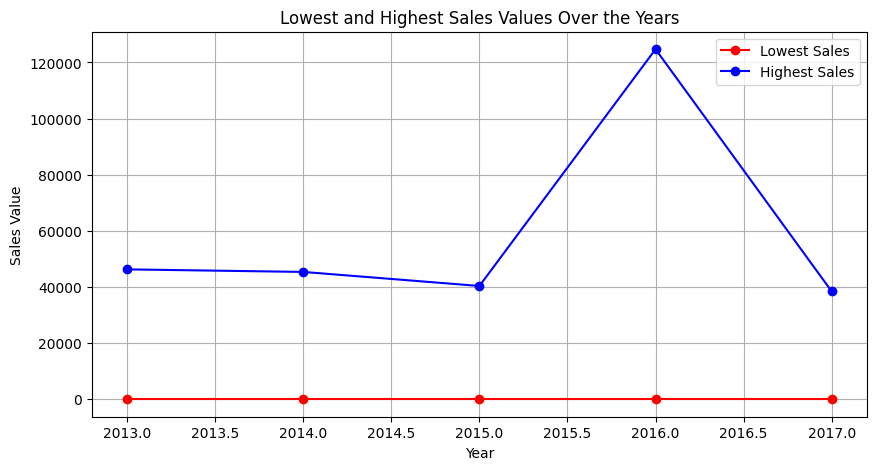

In [110]:
#rest dataframe index
result1.reset_index(inplace=True)

# Create a figure and axis for the line plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the lowest sales values as a line
ax.plot(result1['year'], result1['lowest_sales_value'], marker='o', linestyle='-', color='red', label='Lowest Sales')

# Plot the highest sales values as a line
ax.plot(result1['year'], result1['highest_sales_value'], marker='o', linestyle='-', color='blue', label='Highest Sales')

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Sales Value')
ax.set_title('Lowest and Highest Sales Values Over the Years')
ax.legend()

# Show the line plot
plt.grid(True)
plt.show()

3.  Did the earthquake impact sales?

In [111]:
grouped_sales = train_data.groupby(['year', 'date'])['sales'].sum()
#Preview of grouped data
grouped_sales 

year  date      
2013  2013-01-01      2511.618999
      2013-01-02    496092.417944
      2013-01-03    361461.231124
      2013-01-04    354459.677093
      2013-01-05    477350.121229
                        ...      
2017  2017-08-11    826373.722022
      2017-08-12    792630.535079
      2017-08-13    865639.677471
      2017-08-14    760922.406081
      2017-08-15    762661.935939
Name: sales, Length: 1684, dtype: float64

In [112]:
# Define the date range
start_date = pd.to_datetime('2016-04-01')
end_date = pd.to_datetime('2016-04-30')

#grouped_sales.index.get_level_values('date') extracts the date values from the index of the grouped_sales DataFrame.
#This assumes that the date information is present in the index.

# Create a Boolean mask to filter for dates within the range
date_mask = (grouped_sales.index.get_level_values('date') >= start_date) & (grouped_sales.index.get_level_values('date') <= end_date)

# Apply the mask to filter the data
sales_in_date_range = grouped_sales[date_mask]

# Display the sales data within the specified date range
print(sales_in_date_range)

year  date      
2016  2016-04-01    8.724673e+05
      2016-04-02    1.150825e+06
      2016-04-03    1.266908e+06
      2016-04-04    7.952372e+05
      2016-04-05    7.257501e+05
      2016-04-06    7.447848e+05
      2016-04-07    5.879397e+05
      2016-04-08    6.897272e+05
      2016-04-09    9.279814e+05
      2016-04-10    1.008877e+06
      2016-04-11    6.653490e+05
      2016-04-12    6.516570e+05
      2016-04-13    6.726115e+05
      2016-04-14    5.467852e+05
      2016-04-15    6.676063e+05
      2016-04-16    8.621215e+05
      2016-04-17    1.271834e+06
      2016-04-18    1.345921e+06
      2016-04-19    1.152089e+06
      2016-04-20    1.062426e+06
      2016-04-21    2.002160e+06
      2016-04-22    8.570592e+05
      2016-04-23    1.022143e+06
      2016-04-24    1.039370e+06
      2016-04-25    6.800008e+05
      2016-04-26    7.047994e+05
      2016-04-27    6.702881e+05
      2016-04-28    5.433398e+05
      2016-04-29    7.087114e+05
      2016-04-30    1.0673

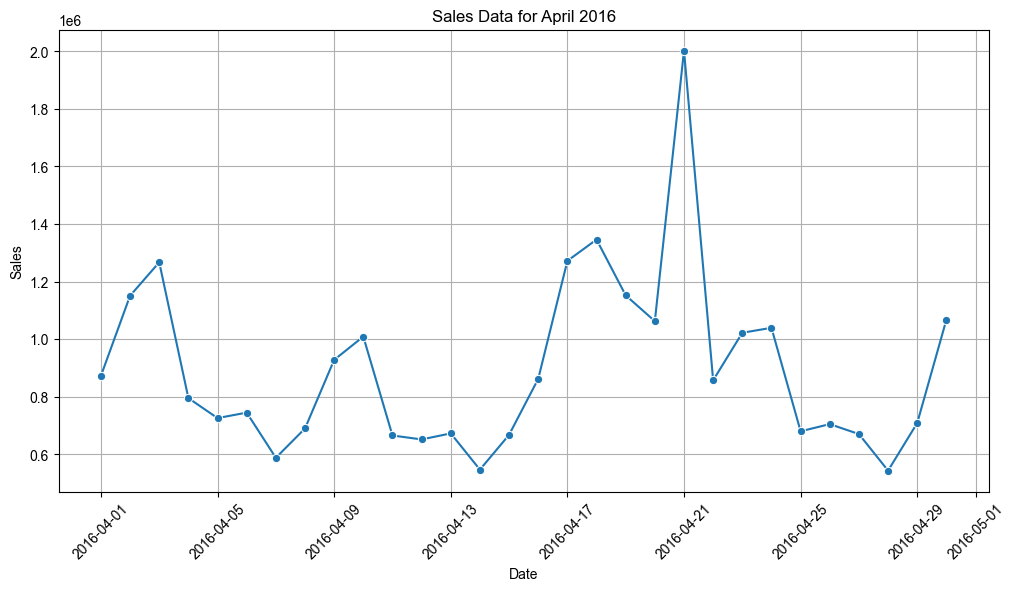

In [113]:
#Vizualization with a Line plot
#Create plot figure
plt.figure(figsize=(12,6))

sns.lineplot(data=sales_in_date_range.reset_index(), x='date', y='sales', marker='o')

#set of label and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Data for April 2016')
sns.set_style('darkgrid')
sns.set_palette('husl')

#Rotate X_axis labels for better readability
plt.xticks(rotation=45)

# Show the line plot
plt.grid(True)
plt.show()

There was a sharp rise in sales most probably due to panic after the occurenceof the earthquake, followed by a sudden decline in the supermarket sales due to relief suport and donations to the affected  by well wishers.

4.  Are certain groups of stores selling more products? (Cluster, city,
    state, type)

In [114]:
group_of_stores = train_data.groupby(['store_nbr', 'city', 'state'])['sales'].sum().reset_index()

#Top ten stores per city, state and sales
group_of_stores1 = group_of_stores.sort_values(by='sales', ascending=False).head(10)
#Preview of dataframe
group_of_stores1

,store_nbr,city,state,sales
43,44,Quito,Pichincha,6.335614e+07
44,45,Quito,Pichincha,5.568902e+07
46,47,Quito,Pichincha,5.202448e+07
2,3,Quito,Pichincha,5.153353e+07
48,49,Quito,Pichincha,4.434682e+07
45,46,Quito,Pichincha,4.280473e+07
47,48,Quito,Pichincha,3.674180e+07
50,51,Guayaquil,Guayas,3.360386e+07
7,8,Quito,Pichincha,3.112407e+07
49,50,Ambato,Tungurahua,2.927375e+07


In [115]:
group_of_stores_sorted = group_of_stores

#group of stores by store number and sales
stores_by_sales = group_of_stores_sorted.groupby('store_nbr')['sales'].sum().reset_index()
#sort dataframe
stores_by_sales_sorted  = stores_by_sales.sort_values(by='sales', ascending=False)

#Preview of sorted stores with most sales(Top Ten)
top_ten_stores_sorted =stores_by_sales_sorted.head(10)

top_ten_stores_sorted 

,store_nbr,sales
43,44,6.335614e+07
44,45,5.568902e+07
46,47,5.202448e+07
2,3,5.153353e+07
48,49,4.434682e+07
45,46,4.280473e+07
47,48,3.674180e+07
50,51,3.360386e+07
7,8,3.112407e+07
49,50,2.927375e+07


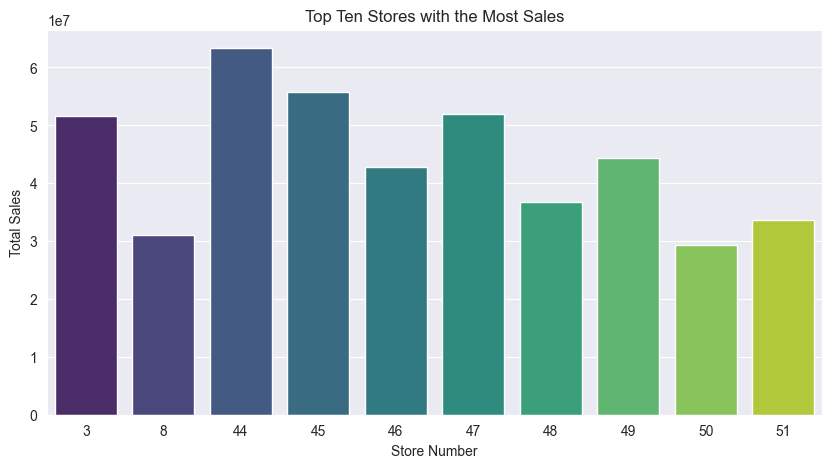

In [116]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Create a bar plot to visualize the top ten stores with most sales
sns.barplot(x='store_nbr', y='sales', data=top_ten_stores_sorted, palette='viridis', ax=ax)

# Set labels and title
ax.set_xlabel('Store Number')
ax.set_ylabel('Total Sales')
ax.set_title('Top Ten Stores with the Most Sales')

# Show the plot
#plt.grid(True)
plt.show()

In [117]:
grouping_sales_by_city = group_of_stores_sorted.groupby('city')['sales'].sum().reset_index()
grouping_sales_by_city_sorted = grouping_sales_by_city.sort_values(by='sales',ascending=False)
#Preview of top ten cities with most sales
top_ten_sales_by_city = grouping_sales_by_city_sorted.head(10)

top_ten_sales_by_city

,city,sales
18,Quito,5.686793e+08
8,Guayaquil,1.255722e+08
3,Cuenca,5.019405e+07
0,Ambato,4.115977e+07
21,Santo Domingo,3.661757e+07
13,Machala,3.409467e+07
2,Cayambe,2.890653e+07
10,Latacunga,2.160778e+07
4,Daule,1.960276e+07
12,Loja,1.924817e+07


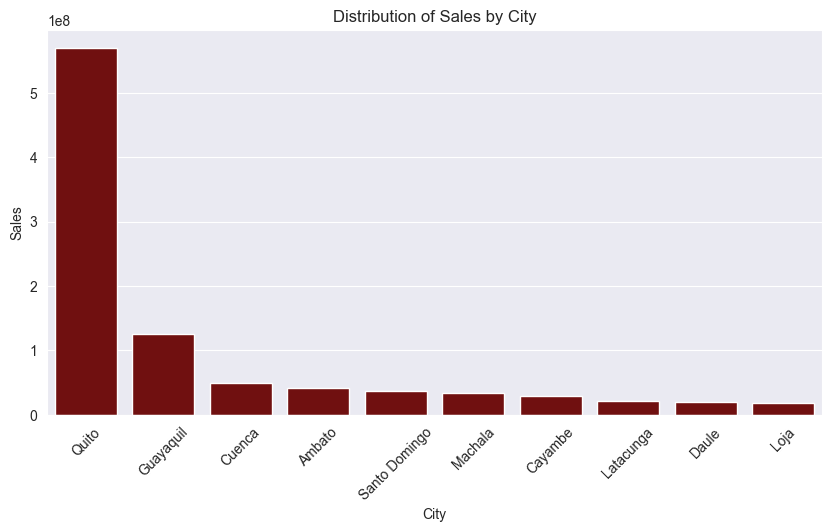

In [118]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the bar plot for city sales
sns.barplot(x=top_ten_sales_by_city['city'], y=top_ten_sales_by_city['sales'], ax=ax, color='maroon',) #label='City Sales')

# Set labels and title
ax.set_xlabel('City')
ax.set_ylabel('Sales')
ax.set_title('Distribution of Sales by City')
#ax.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the combined plot
#plt.grid(True)
plt.show()


In [119]:
group_of_sales_by_state = train_data.groupby('state')['sales'].sum().reset_index()
grouping_sales_by_state_sorted = group_of_sales_by_state.sort_values(by='sales',ascending=False)
top_ten__sales_by_state = grouping_sales_by_state_sorted.head(5)

top_ten__sales_by_state

,state,sales
12,Pichincha,5.975859e+08
6,Guayas,1.686500e+08
0,Azuay,5.019405e+07
15,Tungurahua,4.115977e+07
14,Santo Domingo de los Tsachilas,3.661757e+07


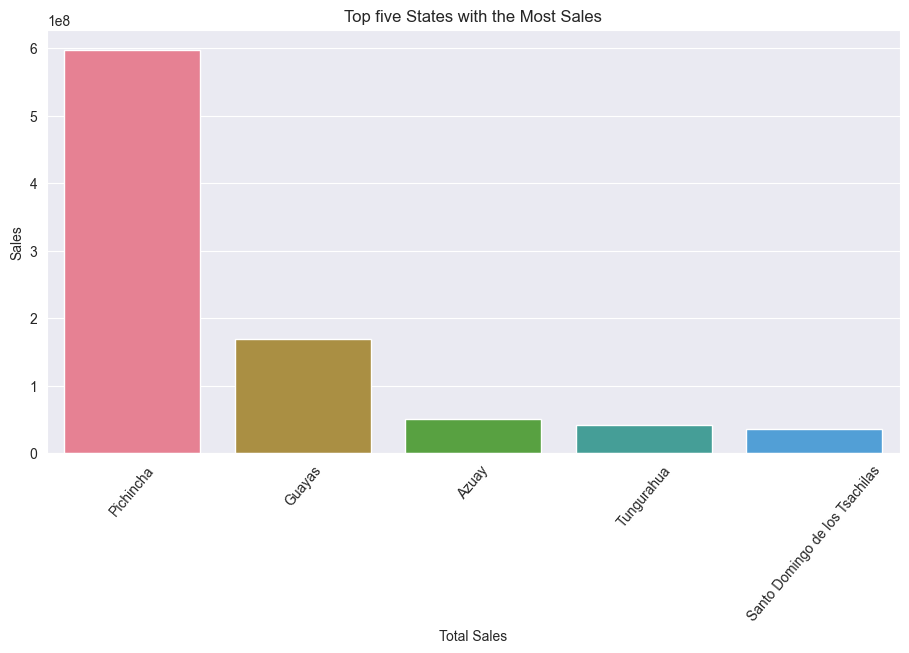

In [120]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(11, 5.5))

# Create a bar plot to visualize the top five stores with most sales
sns.barplot(x='state', y='sales', data=top_ten__sales_by_state, ax=ax)

# Set labels and title
ax.set_xlabel('Total Sales')
ax.set_ylabel('Sales')
ax.set_title('Top five States with the Most Sales')
plt.xticks(rotation=50)
sns.set_style('darkgrid')
sns.set_palette('husl')

# Show the plot
#plt.grid(True)
plt.show()

5.  Are sales affected by promotions, oil prices and holidays?

In [144]:
# Perform one-hot encoding on holiday types
#make a copy of train dataset
train_dataA = train_data.copy()
#Convert dataframe column to "category"
train_dataA['holiday_types'] = train_dataA['holiday_types'].astype('category')
train_dataA['holiday_types'].dtype

CategoricalDtype(categories=['Additional', 'Bridge', 'Event', 'Holiday', 'Not a Holiday',
                  'Transfer', 'Work Day'],
, ordered=False)

In [134]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the 'holiday_types' column
holiday_encoded = encoder.fit_transform(train_dataA['holiday_types'].values.reshape(-1, 1))

# Get the feature names after one-hot encoding
holiday_feature_names = encoder.get_feature_names_out(['holiday_types'])

# Create a DataFrame with the one-hot encoded values and column names
holiday_encoded_df = pd.DataFrame(holiday_encoded, columns=holiday_feature_names)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df = pd.concat([train_dataA, holiday_encoded_df], axis=1)

# Drop the original 'holiday_types' column
df.drop(columns=['holiday_types'], inplace=True)

# Check the resulting DataFrame
df.head(3)

,date,store_nbr,family,sales,onpromotion,Oil_prices,city,state,transferred,year,month,day,holiday_types_Additional,holiday_types_Bridge,holiday_types_Event,holiday_types_Holiday,holiday_types_Not a Holiday,holiday_types_Transfer,holiday_types_Work Day
0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.139999,Quito,Pichincha,False,2013,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2013-01-01,1,BABY CARE,0.0,0,93.139999,Quito,Pichincha,False,2013,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2013-01-01,1,BEAUTY,0.0,0,93.139999,Quito,Pichincha,False,2013,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2013-01-01,1,BEVERAGES,0.0,0,93.139999,Quito,Pichincha,False,2013,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2013-01-01,1,BOOKS,0.0,0,93.139999,Quito,Pichincha,False,2013,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [143]:
# Calculate the correlation matrix for numerical columns
correlation_matrix1 = df[['sales', 'onpromotion', 'Oil_prices', 'holiday_types_Additional', 'holiday_types_Bridge',
                         'holiday_types_Event', 'holiday_types_Holiday', 'holiday_types_Not a Holiday',
                         'holiday_types_Transfer', 'holiday_types_Work Day']].corr()

relevant_features = correlation_matrix1['sales'].sort_values(ascending=False)
relevant_features

sales                          1.000000
onpromotion                    0.428241
holiday_types_Additional       0.017489
holiday_types_Event            0.011060
holiday_types_Transfer         0.007134
holiday_types_Bridge           0.003318
holiday_types_Work Day         0.000642
holiday_types_Holiday         -0.000177
holiday_types_Not a Holiday   -0.013964
Oil_prices                    -0.075570
Name: sales, dtype: float64

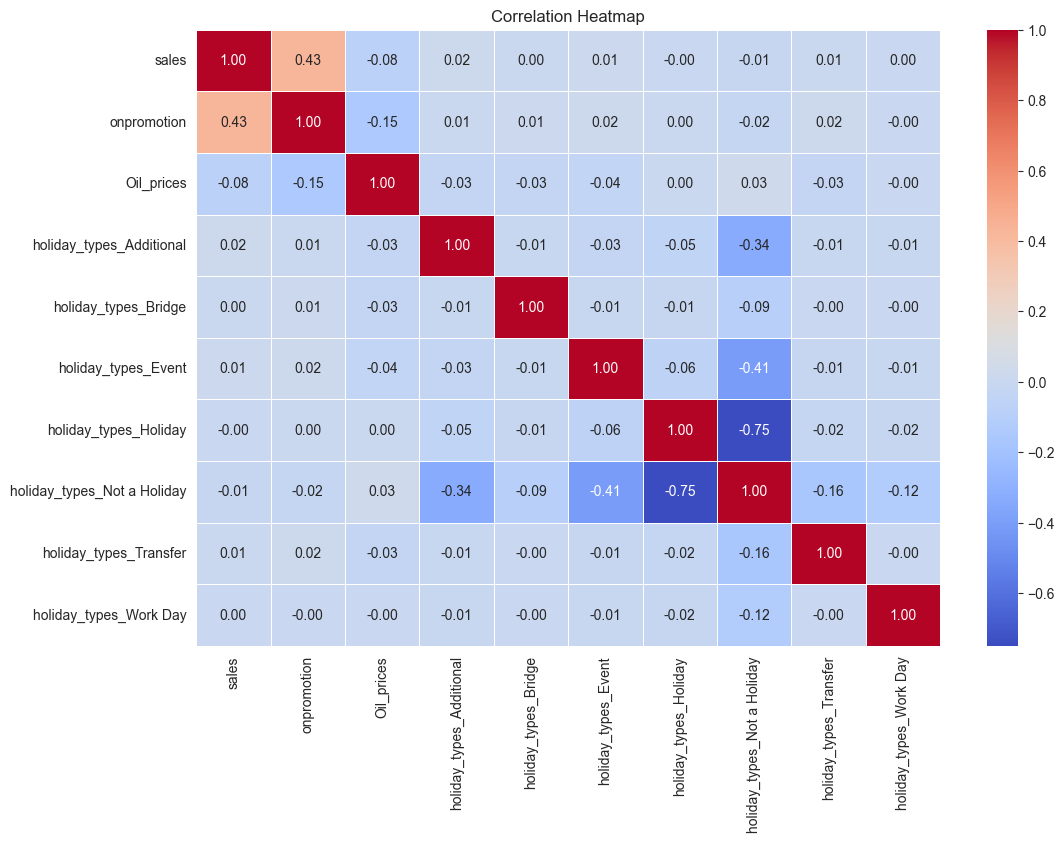

In [145]:
#Heatmap to aid in visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()


The strongest correlation with sales is the "onpromotion" variable, indicating that promotions have a moderate positive effect on sales. There are very weak positive correlation between sales and some some holiday-related categorical variables, such as "holiday_types_Additional" and "holiday_types_Event." Oil prices have a weak negative correlation with sales, suggesting a minor impact(oil prices increase, sales tend to decrease slightly). Most of the holiday-related categorical variables have weak to negligible correlations with sales, indicating that holidays do not have a significant direct impact on sales in this dataset.

  What analysis can we get from the date and its extractable features?

In [154]:
# Create a pivot table to calculate the mean 'month' for each 'year' and 'sales'
pivot_table = train_data.pivot_table(index=['year', 'month'], values='sales', aggfunc='mean')

# Reset the index to make it a DataFrame
pivot_table.reset_index(inplace=True)

# Print the resulting DataFrame
print(pivot_table)


    year  month       sales
0   2013      1  186.952405
1   2013      2  193.581846
2   2013      3  206.880581
3   2013      4  205.639071
4   2013      5  210.184563
5   2013      6  215.691343
6   2013      7  203.983455
7   2013      8  212.479434
8   2013      9  220.593588
9   2013     10  213.164266
10  2013     11  231.136537
11  2013     12  298.675144
12  2014      1  342.341709
13  2014      2  241.268892
14  2014      3  368.661236
15  2014      4  240.577087
16  2014      5  242.203129
17  2014      6  244.634652
18  2014      7  350.830102
19  2014      8  251.351805
20  2014      9  374.530792
21  2014     10  369.213666
22  2014     11  384.056027
23  2014     12  459.818606
24  2015      1  269.666595
25  2015      2  275.420792
26  2015      3  282.368624
27  2015      4  279.743138
28  2015      5  320.958116
29  2015      6  397.249619
30  2015      7  403.030170
31  2015      8  415.692304
32  2015      9  434.734053
33  2015     10  432.248428
34  2015     11  426

In [155]:
# Group the data by 'year' and 'month' and calculate the mean sales for each group
mean_sales_by_year_month = train_data.groupby(['year', 'month'])['sales'].mean()

# Reset the index to make it a DataFrame
mean_sales_by_year_month = mean_sales_by_year_month.reset_index()

# Print the resulting DataFrame
print(mean_sales_by_year_month)

    year  month       sales
0   2013      1  186.952405
1   2013      2  193.581846
2   2013      3  206.880581
3   2013      4  205.639071
4   2013      5  210.184563
5   2013      6  215.691343
6   2013      7  203.983455
7   2013      8  212.479434
8   2013      9  220.593588
9   2013     10  213.164266
10  2013     11  231.136537
11  2013     12  298.675144
12  2014      1  342.341709
13  2014      2  241.268892
14  2014      3  368.661236
15  2014      4  240.577087
16  2014      5  242.203129
17  2014      6  244.634652
18  2014      7  350.830102
19  2014      8  251.351805
20  2014      9  374.530792
21  2014     10  369.213666
22  2014     11  384.056027
23  2014     12  459.818606
24  2015      1  269.666595
25  2015      2  275.420792
26  2015      3  282.368624
27  2015      4  279.743138
28  2015      5  320.958116
29  2015      6  397.249619
30  2015      7  403.030170
31  2015      8  415.692304
32  2015      9  434.734053
33  2015     10  432.248428
34  2015     11  426

Text(0, 0.5, 'Mean Sales')

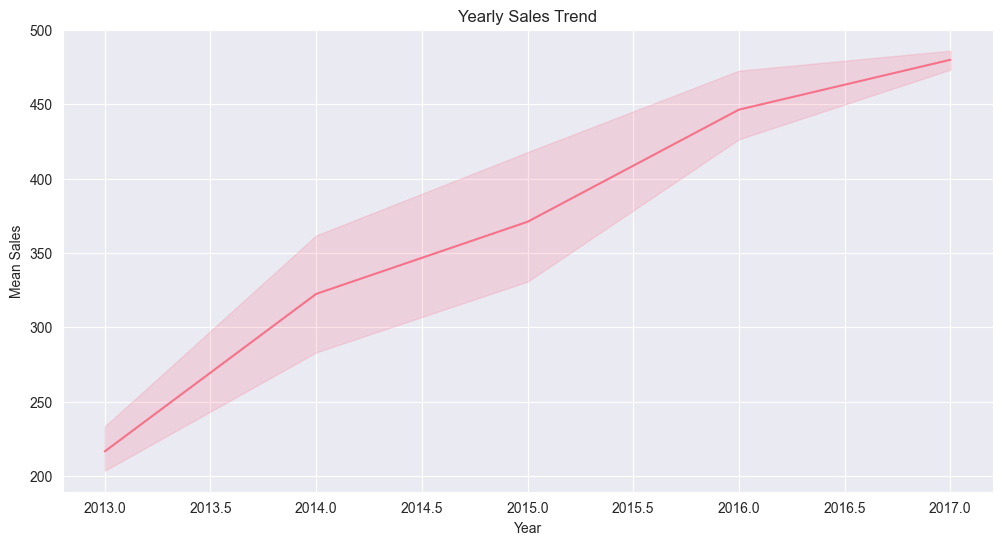

In [164]:
# Assuming you have a DataFrame called mean_sales_by_year_month
# It should have columns 'year', 'month', and 'sales' as calculated in the previous step

# Create a figure with two subplots, one for yearly sales and one for monthly sales
fig, ax1 = plt.subplots(1, figsize=(12, 6))

# Plot the yearly sales trend
sns.lineplot(data=mean_sales_by_year_month, x='year', y='sales', ax=ax1)
ax1.set_title('Yearly Sales Trend')
ax1.set_xlabel('Year')
ax1.set_ylabel('Mean Sales')

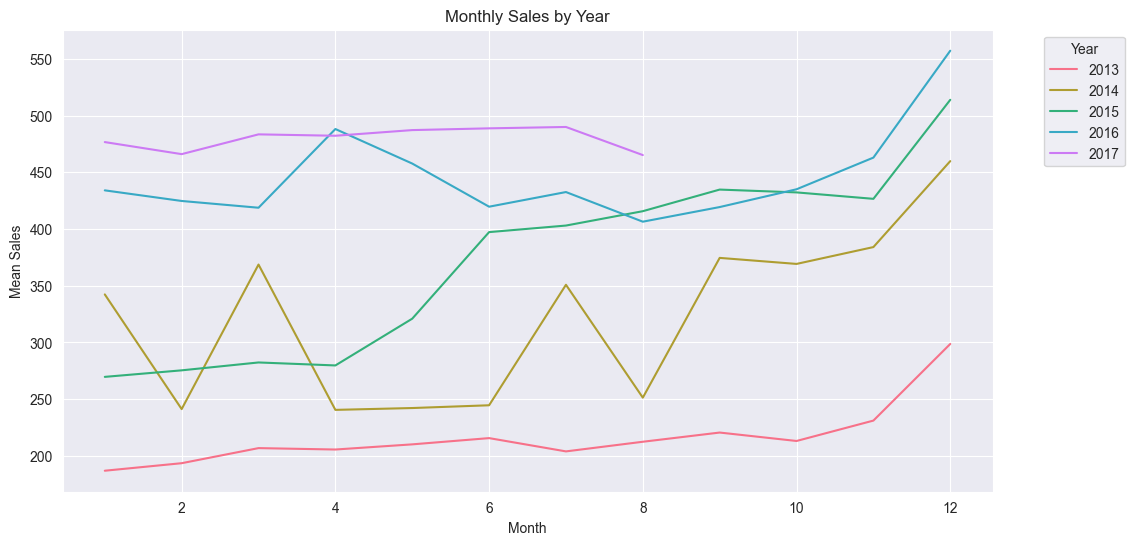

In [163]:
# Define a custom color palette
# we define a custom color palette using Seaborn's "husl" palette
custom_palette = sns.color_palette("husl", n_colors=len(mean_sales_by_year_month['year'].unique()))
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot monthly sales for each year with the custom color palette
sns.lineplot(data=mean_sales_by_year_month, x='month', y='sales', hue='year', ax=ax, palette=custom_palette)

# Set labels and legend
ax.set_xlabel('Month')
ax.set_ylabel('Mean Sales')
ax.set_title('Monthly Sales by Year')

# Show legend
plt.legend(title='Year', loc='upper right', bbox_to_anchor=(1.15, 1))

plt.show()


There's seasonality towards end  of the year characterised by increase in sales over all the years. This is particularly from August to December of each year.

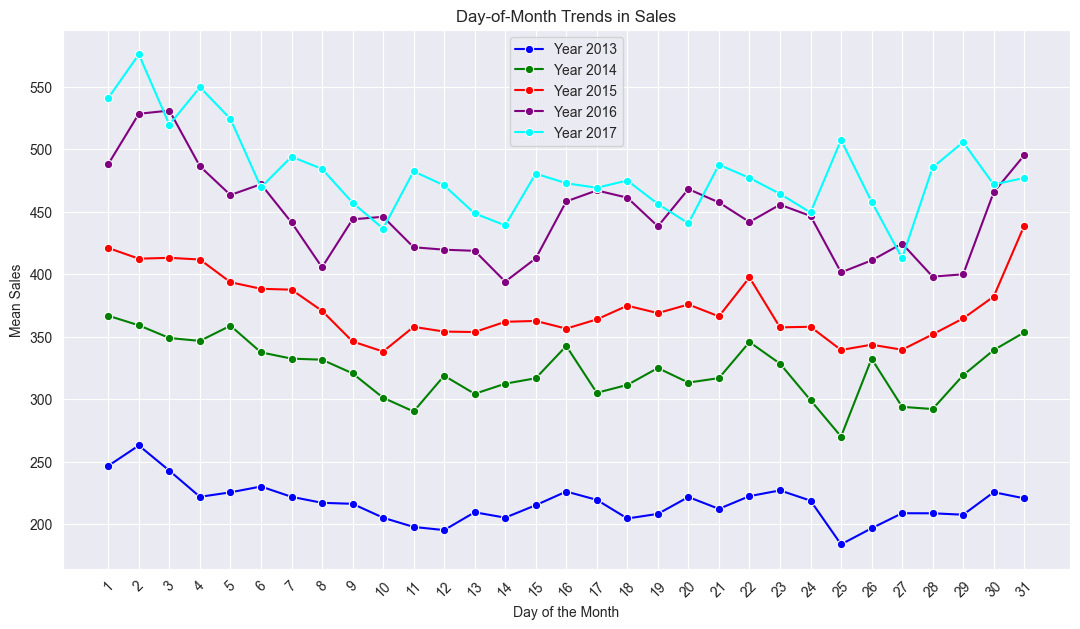

In [176]:
# Create a line plot for each year to visualize day-of-month trends
plt.figure(figsize=(13, 7))

# Define custom colors for each year
custom_colors = {
    2013: 'blue',
    2014: 'green',
    2015: 'red',
    2016: 'purple',
    2017: 'cyan'
}

# Iterate over unique years in your data
for year in train_data['year'].unique():
    year_data = train_data[train_data['year'] == year]
    day_of_month_sales = year_data.groupby('day')['sales'].mean().reset_index()
    sns.lineplot(data=day_of_month_sales, x='day', y='sales', marker='o', label=f'Year {year}',  color=custom_colors.get(year, 'black'))

plt.title('Day-of-Month Trends in Sales')
plt.xlabel('Day of the Month')
plt.ylabel('Mean Sales')
plt.xticks(range(1, 32), rotation=45)
plt.grid(True)
plt.legend()
plt.show();

There are high sales at the beginning and end of each month. The first four days at start of each month have high sales, followed by gradual decline in sales over the days until the last five days of the month that we see again increase in sales

Hypothesis testing

Testing Null hypothesis

Null Hypothesis (H0): There is no significant difference in sales between products on promotion and products not on promotion.

In [148]:
# Separate data into two groups
on_promotion = train_data[train_data['onpromotion'] == 1]['sales']
not_on_promotion = train_data[train_data['onpromotion'] == 0]['sales']

# Perform an independent samples t-test
t_statistic, p_value = stats.ttest_ind(on_promotion, not_on_promotion, equal_var=False)

# Set your significance level (alpha)
alpha = 0.05

# Compare p-value to alpha
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in sales.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in sales.")

Reject the null hypothesis: There is a significant difference in sales.


 promotions have a statistically significant impact on sales.

#### Check for Stationarity

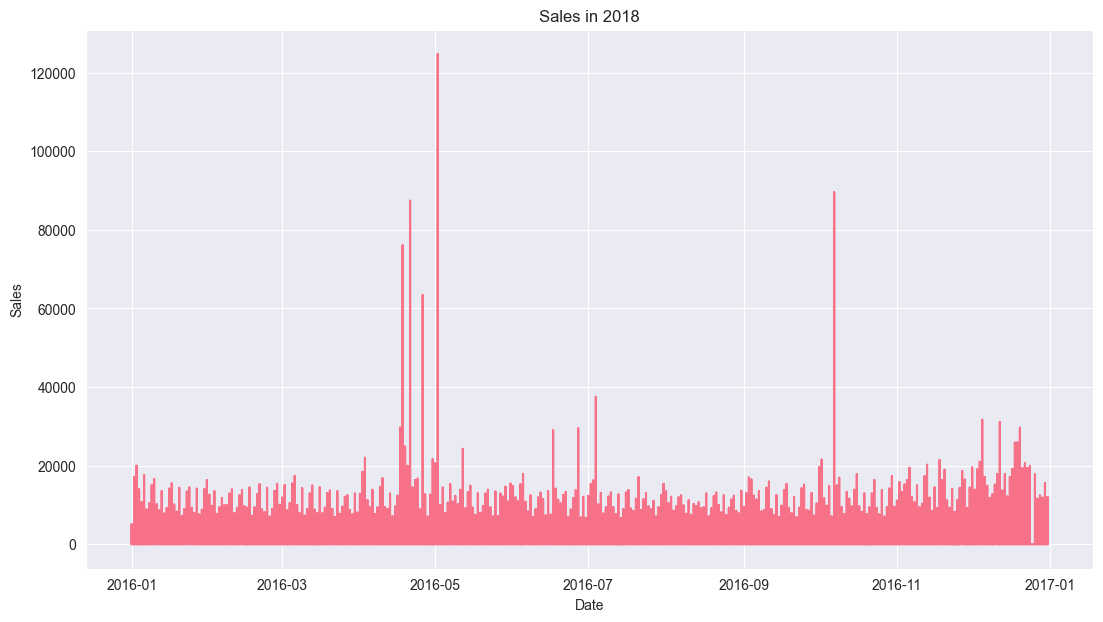

In [197]:
# Filter the DataFrame for the year 2018
sales_2016 = train_data[train_data['year'] == 2016]

# Create a line plot for sales in 2018
plt.figure(figsize=(13, 7))
plt.plot(sales_2016['date'], sales_2016['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales in 2018')
plt.show()
